# Movielens 영화 추천 실습
---

MF 모델 학습 방법을 토대로, 내가 좋아할 만한 영화 추천 시스템을 제작해 보자✊✊

## STEP 0. 설계
---
다음과 같은 순서로 영화 추천 시스템을 구축해보고자 한다.

1. 자료수집 : Movielens 데이터를 다운로드 받는다. [link](http://files.grouplens.org/datasets/movielens/ml-1m.zip)
2. 데이터 준비와 전처리
    - 데이터를 확인하고 학습에 필요한 전처리를 진행한다.
    - 별점을 시청횟수로 해석해서 처리한다.
    - 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외하도록 한다.

## STEP1. 데이터 탐색하기와 전처리
---

### 데이터 받기

In [1]:
# 1) wget으로 데이터 다운로드
# ! wget http://files.grouplens.org/datasets/movielens/ml-1m.zip -P ./data

# 2) 압축 해제
# ! unzip ./data/ml-1m.zip ./data

### 데이터 준비

#### 평점 데이터 준비

- load data

In [4]:
import os
import pandas as pd

%config Completer.use_jedi = False
%load_ext autotime

DATA_DIR_PATH = os.getenv('HOME') + '/workspace/aiffel-exploration-workspace/E08_recommender_system/data'

time: 383 µs (started: 2021-02-16 19:46:36 +09:00)


In [5]:
rating_file_path = DATA_DIR_PATH + '/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python')
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


time: 3.51 s (started: 2021-02-16 19:46:37 +09:00)


- rating 점수가 3점 이상인 데이터만 남긴다.

In [6]:
ratings = ratings[ratings['rating']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%
time: 19.9 ms (started: 2021-02-16 19:46:41 +09:00)


- rating 컬럼의 이름을 count로 변경한다.

In [7]:
ratings.rename(columns={'rating':'count'}, inplace=True)
ratings['count']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: count, Length: 836478, dtype: int64

time: 5.26 ms (started: 2021-02-16 19:46:43 +09:00)


- 결측치 확인

In [8]:
ratings.isnull().sum()

user_id      0
movie_id     0
count        0
timestamp    0
dtype: int64

time: 17.9 ms (started: 2021-02-16 19:46:44 +09:00)


#### 영화 데이터 준비

- load data

In [9]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path  = DATA_DIR_PATH + '/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


time: 16.3 ms (started: 2021-02-16 19:46:44 +09:00)


- 결측치 확인

In [10]:
movies.isnull().sum()

movie_id    0
title       0
genre       0
dtype: int64

time: 4.3 ms (started: 2021-02-16 19:46:45 +09:00)


#### 데이터셋 합치기

- ratings 데이터에 movies의 title, genre가 함께 명시되는 편이 프로젝트를 진행하는 것에 수훨할 것이다.

In [11]:
ratings = pd.merge(ratings, movies, how='inner', left_on='movie_id', right_on='movie_id')
ratings

,user_id,movie_id,count,timestamp,title,genre
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama
...,...,...,...,...,...,...
836473,5851,3607,5,957756608,One Little Indian (1973),Comedy|Drama|Western
836474,5854,3026,4,958346883,Slaughterhouse (1987),Horror
836475,5854,690,3,957744257,"Promise, The (Versprechen, Das) (1994)",Romance
836476,5938,2909,4,957273353,"Five Wives, Three Secretaries and Me (1998)",Documentary


time: 87.4 ms (started: 2021-02-16 19:46:45 +09:00)


#### 불필요한 column 제거

- timestamp는 추천에 사용되지도 않으며 영화에 대한 유의미한 정보도 아니므로 제거한다.

In [12]:
ratings = ratings.drop('timestamp', axis=1)
ratings.columns

Index(['user_id', 'movie_id', 'count', 'title', 'genre'], dtype='object')

time: 16.8 ms (started: 2021-02-16 19:46:46 +09:00)


### 데이터 탐색

- ratings에 있는 유니크한 영화 개수


In [13]:
ratings['movie_id'].nunique()

3628

time: 10.9 ms (started: 2021-02-16 19:46:46 +09:00)


- movie에 있는 유니크한 영화 개수

In [14]:
movies['movie_id'].nunique()

3883

time: 7.6 ms (started: 2021-02-16 19:46:47 +09:00)


- rating에 있는 유니크한 사용자 수


In [15]:
ratings['user_id'].nunique()

6039

time: 20.9 ms (started: 2021-02-16 19:46:48 +09:00)


- rating의 최대/최소값

In [16]:
ratings['count'].agg(['max','min'])

max    5
min    3
Name: count, dtype: int64

time: 12.4 ms (started: 2021-02-16 19:46:48 +09:00)


- 가장 인기 있는 영화 30개(인기순) : 영화를 시청한 사람수, 시청한 사람수가 같다면 영화의 평균 시청 횟수가 높을 수록 인기가 많은 영화라고 판단하였다.

In [17]:
rating_count = ratings.groupby('movie_id')['count'].count().reset_index(name='count_cnt')
rating_mean = ratings.groupby('movie_id')['count'].mean().reset_index(name='count_mean')

time: 29.6 ms (started: 2021-02-16 19:46:48 +09:00)


In [18]:
rating_fav = pd.merge(rating_count, rating_mean, how='inner', on='movie_id')
rating_fav = rating_fav.sort_values(by=['count_cnt', 'count_mean'], ascending=False)

rating_fav_top_30 = rating_fav.head(30)
rating_fav_top_30 = pd.merge(rating_fav_top_30, movies, how='left', on='movie_id')
rating_fav_top_30.index = range(1, len(rating_fav_top_30)+1)

rating_fav_top_30

,movie_id,count_cnt,count_mean,title,genre
1,2858,3211,4.499844,American Beauty (1999),Comedy|Drama
2,260,2910,4.528522,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
3,1196,2885,4.384055,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
4,1210,2716,4.161635,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
5,2028,2561,4.431082,Saving Private Ryan (1998),Action|Drama|War
6,589,2509,4.190116,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
7,593,2498,4.441954,"Silence of the Lambs, The (1991)",Drama|Thriller
8,1198,2473,4.520421,Raiders of the Lost Ark (1981),Action|Adventure
9,1270,2460,4.097967,Back to the Future (1985),Comedy|Sci-Fi
10,2571,2434,4.479458,"Matrix, The (1999)",Action|Sci-Fi|Thriller


time: 20.9 ms (started: 2021-02-16 19:46:49 +09:00)


### 모델 검증을 위한 사용자 초기 정보 세팅

- movie에 포함된 영화 중 선호하는 영화를 5가지 골라서 ratings에 추가한다.

- 선호 영화 선정 및 평점 정의

In [19]:
my_movie_id = [39 , 1721 , 1801, 3825, 2671]
my_count = [5, 5, 5, 5, 5]

time: 1.04 ms (started: 2021-02-16 19:46:50 +09:00)


- 새 아이디 생성 : ratings의 user_id에 등장하지 않는 int형 값을 찾아 `my_id`로 정의한다.

In [20]:
ids = ratings['user_id'].unique()
my_id = ids[-1] + 1
while my_id in ids: my_id += 1

time: 23.1 ms (started: 2021-02-16 19:46:50 +09:00)


- 나머지 column에 들어갈 값 정의

In [21]:
my_title = [ movies[movies['movie_id']==_id]['title'].values[0] for _id in my_movie_id ]
my_genre = [ movies[movies['movie_id']==_id]['genre'].values[0] for _id in my_movie_id ]

time: 7.38 ms (started: 2021-02-16 19:46:50 +09:00)


- ratings에 데이터 삽입

In [22]:
my_ratings_df = pd.DataFrame({'user_id' : [my_id]*5, 
                              'movie_id' : my_movie_id,
                              'count' : my_count,
                              'title' : my_title,
                              'genre' : my_genre})

if not ratings.isin({'user_id':[my_id]})['user_id'].any():
    ratings_updated = ratings.append(my_ratings_df).reset_index(drop=True)

ratings_updated.tail(10)

,user_id,movie_id,count,title,genre
836473,5851,3607,5,One Little Indian (1973),Comedy|Drama|Western
836474,5854,3026,4,Slaughterhouse (1987),Horror
836475,5854,690,3,"Promise, The (Versprechen, Das) (1994)",Romance
836476,5938,2909,4,"Five Wives, Three Secretaries and Me (1998)",Documentary
836477,5948,1360,5,Identification of a Woman (Identificazione di ...,Drama
836478,6041,39,5,Clueless (1995),Comedy|Romance
836479,6041,1721,5,Titanic (1997),Drama|Romance
836480,6041,1801,5,"Man in the Iron Mask, The (1998)",Action|Drama|Romance
836481,6041,3825,5,Coyote Ugly (2000),Drama
836482,6041,2671,5,Notting Hill (1999),Comedy|Romance


time: 88.8 ms (started: 2021-02-16 19:46:51 +09:00)


### 모델에 활용하기 위한 전처리 - Indexing

In [23]:
user_unique = ratings_updated['user_id'].unique()
user_to_idx = {v:k for k,v in enumerate(user_unique)}

movie_unique = ratings_updated['movie_id'].unique()
movie_id_to_idx = {v:k for k,v in enumerate(movie_unique)}
movie_idx_to_id = {k:v for k,v in enumerate(movie_unique)}

time: 12.6 ms (started: 2021-02-16 19:46:51 +09:00)


In [24]:
# 인덱싱 확인
print(user_to_idx[my_id])

6039
time: 1.1 ms (started: 2021-02-16 19:46:52 +09:00)


In [25]:
temp_user_data = ratings_updated['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(ratings_updated):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    ratings_updated['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

temp_movie_data = ratings_updated['movie_id'].map(movie_id_to_idx.get).dropna()
if len(temp_movie_data) == len(ratings_updated):
    print('movie_id column indexing OK!!')
    ratings_updated['movie_idx'] = temp_movie_data
else:
    print('movie_id column indexing Fail!!')

ratings_updated = ratings_updated[['user_id', 'movie_idx', 'movie_id', 'count', 'title', 'genre']]
ratings_updated = ratings_updated.reset_index(drop=True)
ratings_updated

user_id column indexing OK!!
movie_id column indexing OK!!


,user_id,movie_idx,movie_id,count,title,genre
0,0,0,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,0,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama
2,2,0,1193,4,One Flew Over the Cuckoo's Nest (1975),Drama
3,3,0,1193,4,One Flew Over the Cuckoo's Nest (1975),Drama
4,4,0,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama
...,...,...,...,...,...,...
836478,6039,204,39,5,Clueless (1995),Comedy|Romance
836479,6039,27,1721,5,Titanic (1997),Drama|Romance
836480,6039,112,1801,5,"Man in the Iron Mask, The (1998)",Action|Drama|Romance
836481,6039,2047,3825,5,Coyote Ugly (2000),Drama


time: 648 ms (started: 2021-02-16 19:46:52 +09:00)


## STEP2. CSR
---

In [26]:
from scipy.sparse import csr_matrix
import numpy as np
from pandas.api.types import CategoricalDtype

time: 1.17 ms (started: 2021-02-16 19:46:53 +09:00)


In [27]:
num_user = ratings_updated['user_id'].nunique()
num_movie = ratings_updated['movie_idx'].nunique()

csr_data = csr_matrix((ratings_updated['count'], 
                       (ratings_updated.user_id, ratings_updated.movie_idx)), 
                       shape=(num_user, num_movie))
csr_data

<6040x3628 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

time: 67 ms (started: 2021-02-16 19:46:54 +09:00)


In [28]:
print(f'indptr: {csr_data.indptr}({len(csr_data.indptr)})')
print(f'indices: {csr_data.indices}({len(csr_data.indices)})')
print(f'data: {csr_data.data}({len(csr_data.data)})')

indptr: [     0     53    169 ... 836477 836478 836483](6041)
indices: [   0    1    2 ...  204 1151 2047](836483)
data: [5 3 3 ... 5 5 5](836483)
time: 3.33 ms (started: 2021-02-16 19:46:54 +09:00)


## STEP3. MF 모델 학습하기
---

### 모델 학습

In [29]:
from implicit.als import AlternatingLeastSquares

os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

time: 42.9 ms (started: 2021-02-16 19:46:57 +09:00)


In [30]:
als_model = AlternatingLeastSquares(factors=256, 
                                    regularization=0.01, 
                                    use_gpu=False, 
                                    iterations=10,
                                    dtype=np.float64)

time: 441 µs (started: 2021-02-16 19:46:58 +09:00)


In [31]:
csr_data_transpose = csr_data.T
print(f'indptr: {csr_data_transpose.indptr}({len(csr_data_transpose.indptr)})')
print(f'indices: {csr_data_transpose.indices}({len(csr_data_transpose.indices)})')
print(f'data: {csr_data_transpose.data}({len(csr_data_transpose.data)})')

indptr: [     0     53    169 ... 836477 836478 836483](6041)
indices: [   0    1    2 ...  204 1151 2047](836483)
data: [5 3 3 ... 5 5 5](836483)
time: 1.94 ms (started: 2021-02-16 19:46:59 +09:00)


In [32]:
als_model.fit(csr_data_transpose)

  0%|          | 0/10 [00:00<?, ?it/s]

time: 5.74 s (started: 2021-02-16 19:47:00 +09:00)


### 학습 결과 확인

#### 내가 선호하는 영화들에 대한 나의 선호도 예측

In [33]:
my_vector = als_model.user_factors[user_to_idx[my_id]]
favorit_movie_vector = [ als_model.item_factors[movie_id_to_idx[movie_id]] for movie_id in my_movie_id ]
my_movie_preference = [ np.dot(my_vector, mv) for mv in favorit_movie_vector ]

time: 733 µs (started: 2021-02-16 19:47:06 +09:00)


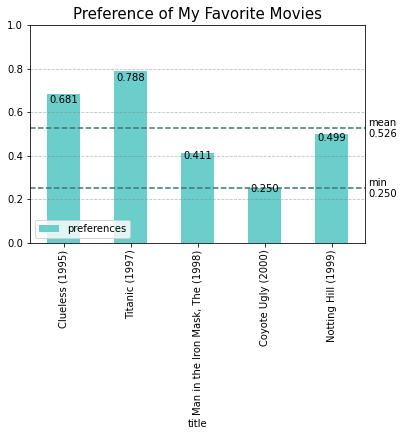

time: 189 ms (started: 2021-02-16 19:47:06 +09:00)


In [34]:
my_movie_preference_df = pd.DataFrame({'movie_id' : my_movie_id,
                                       'title' : my_title,
                                       'genre' : my_genre,
                                       'preference': my_movie_preference})
show_preference_df_plot(my_movie_preference_df)

- 모든 영화에 대하여 선호도를 최대값(5)로 설정하였기 때문에 1과 근사한 값이 나올 것이라 예상하였으나, 평균이 거의 딱 1의 절반인 0.533인 결과를 얻었다.

#### 내가 선호하는 영화와 비슷한 영화를 추천받아 보자

In [35]:
def get_similar_movie_with_score(movie_id: str):
    movie_idx = movie_id_to_idx[movie_id]
    similar_movie = als_model.similar_items(movie_idx)
    similar_movies = [[movie_idx_to_id[e[0]], e[1]] if e[0]!= movie_id else _ for e in similar_movie[1:6]]
    return similar_movies

time: 614 µs (started: 2021-02-16 19:47:09 +09:00)


In [36]:
def get_similar_movies_df(movie_id: str):
    similar_movies = get_similar_movie_with_score(movie_id)
    similar_movies_df = pd.DataFrame(columns=['movie_id', 'score'],
                                     data=similar_movies)
    similar_movies_df = pd.merge(similar_movies_df, movies, on='movie_id', how='left')
    similar_movies_df.index = range(1,6)
    return similar_movies_df

time: 551 µs (started: 2021-02-16 19:47:10 +09:00)


In [37]:
similar_movies_dfs = [ get_similar_movies_df(movie_id) for movie_id in my_movie_id]

for title, genre, df in zip(my_title, my_genre, similar_movies_dfs):
    print(f'{title} - {genre}')
    display(df)
    print('\n\n')

Clueless (1995) - Comedy|Romance


,movie_id,score,title,genre
1,1456,0.412467,"Pest, The (1997)",Comedy
2,2168,0.403525,Dance with Me (1998),Drama|Romance
3,357,0.398938,Four Weddings and a Funeral (1994),Comedy|Romance
4,810,0.391037,Kazaam (1996),Children's|Comedy|Fantasy
5,217,0.389934,"Babysitter, The (1995)",Drama|Thriller





Titanic (1997) - Drama|Romance


,movie_id,score,title,genre
1,3286,0.326968,Snow Day (2000),Comedy
2,2424,0.323284,You've Got Mail (1998),Comedy|Romance
3,3586,0.318515,"Idolmaker, The (1980)",Drama
4,336,0.317038,"Walking Dead, The (1995)",Drama|War
5,1436,0.311523,Falling in Love Again (1980),Comedy





Man in the Iron Mask, The (1998) - Action|Drama|Romance


,movie_id,score,title,genre
1,694,0.618149,"Substitute, The (1996)",Action
2,168,0.602442,First Knight (1995),Action|Adventure|Drama|Romance
3,2965,0.598257,"Omega Code, The (1999)",Action
4,3390,0.597749,Shanghai Surprise (1986),Adventure
5,939,0.595439,"Reluctant Debutante, The (1958)",Comedy|Drama





Coyote Ugly (2000) - Drama


,movie_id,score,title,genre
1,3453,0.759931,Here on Earth (2000),Drama|Romance
2,3454,0.703166,Whatever It Takes (2000),Comedy|Romance
3,3861,0.695800,"Replacements, The (2000)",Comedy
4,3225,0.689144,Down to You (2000),Comedy|Romance
5,3857,0.687567,Bless the Child (2000),Thriller





Notting Hill (1999) - Comedy|Romance


,movie_id,score,title,genre
1,1569,0.539215,My Best Friend's Wedding (1997),Comedy|Romance
2,597,0.538261,Pretty Woman (1990),Comedy|Romance
3,539,0.529176,Sleepless in Seattle (1993),Comedy|Romance
4,339,0.513198,While You Were Sleeping (1995),Comedy|Romance
5,2424,0.493691,You've Got Mail (1998),Comedy|Romance





time: 66 ms (started: 2021-02-16 19:47:11 +09:00)


- 노팅힐과 비슷한 영화로 시애틀의 잠못드는 밤, 유브 갓 메일, 내 남자친구의 결혼식, 귀여운 여인이 추천되었다. 로맨스 코메디 장르의 영화들로 서로 비슷하다고 할 수 있는 영화가 잘 추천 되었다. 
- 반면, 클루리스는 대표적인 하이틴 영화이기 때문에 추천 영화들 역시 비슷한 장르일 것이라 예상하였으나, 전혀 다르게 추천 되었고 추천된 영화들 간에도 공통점을 찾기 힘들었다.

#### 내가 좋아할만한 영화들을 추천받아 보자

In [38]:
def get_recommended_df(user_id: str, model):
    movie_recommended = model.recommend(user_id, csr_data, N=20, filter_already_liked_items=True)[:10]
    movie_recommended = [ (movie_idx_to_id[e[0]], e[1]) for e in movie_recommended ]
    movie_recommended_df = pd.DataFrame(columns=['movie_id', 'score'],
                                         data=movie_recommended)
    movie_recommended_df = pd.merge(movie_recommended_df, movies, on='movie_id', how='left')
    movie_recommended_df.index = range(1, 11)
    return movie_recommended_df
    
recommended_df = get_recommended_df(user_to_idx[my_id], als_model)
recommended_df

,movie_id,score,title,genre
1,357,0.246506,Four Weddings and a Funeral (1994),Comedy|Romance
2,1569,0.219293,My Best Friend's Wedding (1997),Comedy|Romance
3,2396,0.209557,Shakespeare in Love (1998),Comedy|Romance
4,440,0.204286,Dave (1993),Comedy|Romance
5,597,0.197946,Pretty Woman (1990),Comedy|Romance
6,3798,0.182792,What Lies Beneath (2000),Thriller
7,1183,0.178374,"English Patient, The (1996)",Drama|Romance|War
8,1393,0.177449,Jerry Maguire (1996),Drama|Romance
9,3785,0.171850,Scary Movie (2000),Comedy|Horror
10,1777,0.166895,"Wedding Singer, The (1998)",Comedy|Romance


time: 16.3 ms (started: 2021-02-16 19:47:28 +09:00)


In [39]:
def get_recommanded_explain(movie_id: str, user_idx: str, model):
    recommanded_movie_idx = movie_id_to_idx[movie_id]
    explain = model.explain(user_idx, csr_data, itemid=recommanded_movie_idx)
    explain_list = [(movie_idx_to_id[i[0]], i[1]) for i in explain[1]]
    return explain_list

time: 589 µs (started: 2021-02-16 19:47:29 +09:00)


In [40]:
def show_recommended_score_explain(recommended_df: pd.DataFrame, user_id: str, model, my_moive_id, my_title):
    overview = pd.DataFrame(columns=['movie_id', *my_movie_id])

    for movie_id in recommended_df['movie_id'].values:
        explain_list = sorted(get_recommanded_explain(movie_id, user_id, model), key=lambda e: e[0]) 
        tmp_df = pd.DataFrame([movie_id, *(e[1] for e in explain_list)]).T
        tmp_df.columns = overview.columns
        overview = overview.append(tmp_df)

    overview = pd.merge(overview, movies, on='movie_id', how='left')
    overview = overview.drop('genre', axis=1)
    overview.columns = ['movie_id', *my_title, 'title']
    overview = overview.set_index('title')
    overview = overview.drop('movie_id', axis=1)

    ax = overview.plot(kind='barh', stacked=True, figsize=(8,7), colormap='RdYlGn')
    ax.set_xlabel('Score Explain', fontdict={'fontsize': 13})
    ax.set_ylabel('Movie Title', fontdict={'fontsize': 13})
    ax.set_title('Recommended Score Explains', fontdict={'fontsize': 20})

    scores = recommended_df['score'].values
    for i in range(10):
        ax.text(1.01, i, f'{scores[i]:.3f}', va='center', ha="left", transform=ax.get_yaxis_transform())

    ax.text(1.01, 9.8, f'Score', va='center', ha="left", transform=ax.get_yaxis_transform(), fontdict={'fontsize': 13})
    ax.grid(True, color='gray', alpha=0.5, linestyle='dashed')
    ax.legend(loc='lower left')

    plt.show()

    display(overview)

time: 1.41 ms (started: 2021-02-16 19:47:30 +09:00)


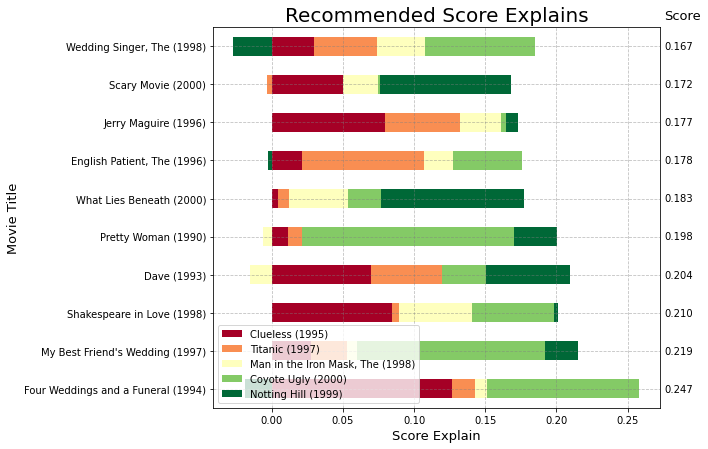

,Clueless (1995),Titanic (1997),"Man in the Iron Mask, The (1998)",Coyote Ugly (2000),Notting Hill (1999)
title,,,,,
Four Weddings and a Funeral (1994),0.126258,0.016199,0.008821,0.106967,-0.019022
My Best Friend's Wedding (1997),0.027400,0.025306,0.007394,0.131575,0.023130
Shakespeare in Love (1998),0.084759,0.004332,0.051331,0.057933,0.003063
Dave (1993),0.069568,0.050351,-0.015342,0.030526,0.059276
Pretty Woman (1990),0.011475,0.009749,-0.006381,0.148842,0.030493
What Lies Beneath (2000),0.003972,0.008014,0.041399,0.023106,0.100811
"English Patient, The (1996)",0.020987,0.085970,0.020581,0.048475,-0.002974
Jerry Maguire (1996),0.079804,0.052156,0.029094,0.003480,0.008418
Scary Movie (2000),0.050178,-0.003373,0.024543,0.001500,0.092085


time: 291 ms (started: 2021-02-16 19:47:30 +09:00)


In [41]:
show_recommended_score_explain(recommended_df, user_to_idx[my_id], als_model, my_movie_id, my_title)

- score 값은 낮지만 상당히 잘 추천 되었다. 특히 귀여운 여인, 스피트, 네 번의 결혼식과 한 번의 장례식, 로미오와 줄리엣은 실제로도 괜찮게 봤던 영화들이어서 더 추천 결과에 신뢰가 갔다.
- 추천된 영화들은 대게 로맨스 장르들로 나의 선호 영화였던 클루리스, 타이타닉, 코요테 어글리, 노팅힐이 모두 로맨스 장르를 포함하고 있는 것에 영향을 받은 것으로 보인다.

## STEP4. 추가실험
---

### 내가 선호하는 영화의 선호도가 1에 근사하였을 경우, 어떤 영화가 추천될까?
- 가설 : 내가 선호하는 영화의 선호도가 1에 근사하다는 것은 나의 선호도 정보가 더 강력하게 학습되었다는 의미이므로 *좋아할만한 혹은 이미 봤음직한* 영화가 추천될 것 같다.

1. 모델의 하이퍼 파라미터를 조절하여 다양한 형태의 모델 정의

In [42]:
als_model_512_20 = AlternatingLeastSquares(factors=512, 
                                           regularization=0.01,
                                           use_gpu=False, 
                                           iterations=20,
                                           dtype=np.float64)

als_model_1024_20 = AlternatingLeastSquares(factors=1024, 
                                           regularization=0.01,
                                           use_gpu=False, 
                                           iterations=20,
                                           dtype=np.float64)

als_model_2048_20 = AlternatingLeastSquares(factors=2048, 
                                           regularization=0.01,
                                           use_gpu=False, 
                                           iterations=20,
                                           dtype=np.float64)

time: 2.42 ms (started: 2021-02-16 19:02:46 +09:00)


2. 모델 학습

In [43]:
models = {
    'als_model_512_20': als_model_512_20,
    'als_model_1024_20': als_model_1024_20,
    'als_model_2048_20': als_model_2048_20,
}

for model in models.values(): model.fit(csr_data_transpose)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

time: 9min 16s (started: 2021-02-16 19:02:48 +09:00)


3. 내가 선호하는 영화들에 대한 선호도 평균이 가장 높은 모델을 선정

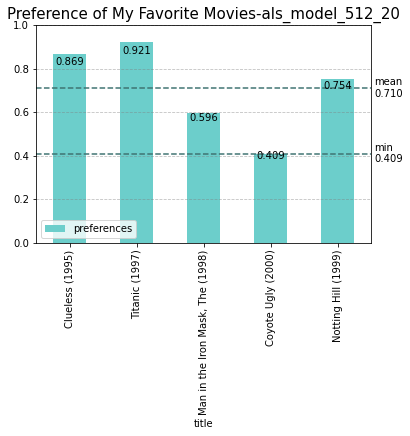

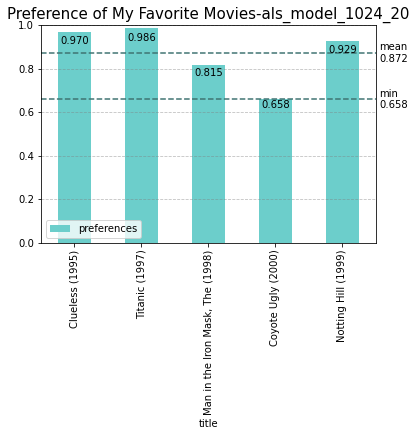

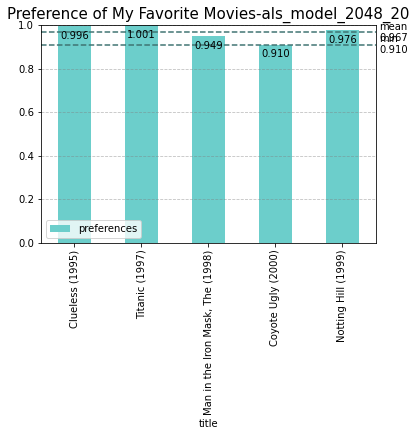

time: 379 ms (started: 2021-02-16 19:14:25 +09:00)


In [44]:
for model_name, model in models.items():
    my_vector = model.user_factors[user_to_idx[my_id]]
    favorit_movie_vector = [ model.item_factors[movie_id_to_idx[movie_id]] for movie_id in my_movie_id ]
    my_movie_preference = [ np.dot(my_vector, mv) for mv in favorit_movie_vector ]
    my_movie_preference_df = pd.DataFrame({'movie_id' : my_movie_id,
                                           'title' : my_title,
                                           'genre' : my_genre,
                                           'preference': my_movie_preference})
    show_preference_df_plot(my_movie_preference_df, f'Preference of My Favorite Movies-{model_name}')

4. 3에서 선정된 모델로부터 내가 좋아할만한 영화를 추천 받아, 결과를 확인해 본다.

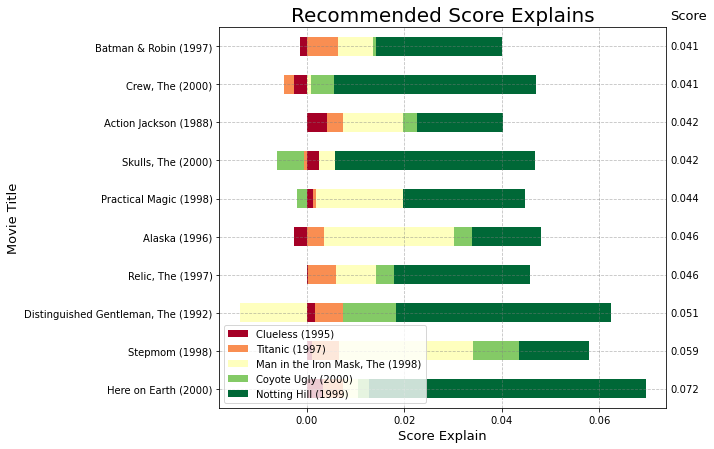

,Clueless (1995),Titanic (1997),"Man in the Iron Mask, The (1998)",Coyote Ugly (2000),Notting Hill (1999)
title,,,,,
Here on Earth (2000),0.003236,0.004261,0.002954,0.002296,0.056741
Stepmom (1998),0.001051,0.005515,0.027428,0.009598,0.014396
"Distinguished Gentleman, The (1992)",0.001686,0.005647,-0.013745,0.010887,0.044255
"Relic, The (1997)",0.000277,0.005807,0.008047,0.003772,0.027869
Alaska (1996),-0.002544,0.003450,0.026809,0.003666,0.014111
Practical Magic (1998),0.001183,0.000742,0.017883,-0.002102,0.024903
"Skulls, The (2000)",0.002421,-0.000464,0.003421,-0.005556,0.040952
Action Jackson (1988),0.004127,0.003393,0.012146,0.003031,0.017651
"Crew, The (2000)",-0.002632,-0.001981,0.000767,0.004892,0.041430


time: 2.26 s (started: 2021-02-16 19:14:30 +09:00)


In [45]:
recommended_df = get_recommended_df(user_to_idx[my_id], models['als_model_2048_20'])
show_recommended_score_explain(recommended_df, user_to_idx[my_id], models['als_model_2048_20'], my_moive_id, my_title)

- 결과 : 이전에 학습되었던 모델에서 추천한 영화의 score 평균은 0.1745였다. 반면 이번 실험에서 얻어진 추천 영화 score의 평균은 0.0484이다. score의 값이 높을수록 유저의 선호도가 높은 것이므로 추천영화라고 했지만, 사실상 유저가 선호할 확률이 매우 희박한 영화 10편이라고 해도 무방할 것이다. 가설이었던 *선호도 정보가 강력하게 학습되었다*가 더 좋은 추천시스템이 구축되었다고 연결되는 것이 아닌 *모델이 오버피팅 되었다*의 다른 말이었다. 

### 내가 선호하는 영화가 마니아적인 성향이 있다면, 어떤 영화가 추천될까?
- 가설 : 만약, 선호영화 목록을 하이틴 로맨스 장르로 가득 채운다면 이는 내가 하이틴 로맨스 장르의 마니아라고 할 수 있을것이다. 이 경우, 하이틴 로맨스로 선호도가 집중되고 다른 장으로는 선호도가 낮게 측정 될 것이므로 추천되는 영화 역시 하이틴 로맨스 장르가 될 것이다.

1. 추가 사용자 초기 정보 생성

In [62]:
mania_movie_id = [ 39, 2145, 2485, 2572, 2706]
mania_count = [5, 5, 5, 5, 5]

ids = ratings['user_id'].unique()
mania_id = ids[-1] + 1
while mania_id in ids: mania_id += 1
    
mania_title = [ movies[movies['movie_id']==_id]['title'].values[0] for _id in mania_movie_id ]
mania_genre = [ movies[movies['movie_id']==_id]['genre'].values[0] for _id in mania_movie_id ]

time: 21 ms (started: 2021-02-16 19:24:34 +09:00)


2. ratings에 데이터 삽입

In [63]:
mania_ratings_df = pd.DataFrame({'user_id' : [mania_id]*5, 
                                 'movie_id' : mania_movie_id,
                                 'count' : mania_count,
                                 'title' : mania_title, 
                                 'genre' : mania_genre})

if not ratings.isin({'user_id':[mania_id]})['user_id'].any():
    ratings_mania = ratings.append(mania_ratings_df).reset_index(drop=True)

ratings_mania.tail(10)

,user_id,movie_id,count,title,genre
836473,5851,3607,5,One Little Indian (1973),Comedy|Drama|Western
836474,5854,3026,4,Slaughterhouse (1987),Horror
836475,5854,690,3,"Promise, The (Versprechen, Das) (1994)",Romance
836476,5938,2909,4,"Five Wives, Three Secretaries and Me (1998)",Documentary
836477,5948,1360,5,Identification of a Woman (Identificazione di ...,Drama
836478,6041,39,5,Clueless (1995),Comedy|Romance
836479,6041,2145,5,Pretty in Pink (1986),Comedy|Drama|Romance
836480,6041,2485,5,She's All That (1999),Comedy|Romance
836481,6041,2572,5,10 Things I Hate About You (1999),Comedy|Romance
836482,6041,2706,5,American Pie (1999),Comedy


time: 84.9 ms (started: 2021-02-16 19:24:35 +09:00)


3. indexing

In [64]:
user_unique = ratings_mania['user_id'].unique()
user_to_idx = {v:k for k,v in enumerate(user_unique)}

movie_unique = ratings_mania['movie_id'].unique()
movie_id_to_idx = {v:k for k,v in enumerate(movie_unique)}
movie_idx_to_id = {k:v for k,v in enumerate(movie_unique)}

time: 27.8 ms (started: 2021-02-16 19:24:35 +09:00)


In [65]:
temp_user_data = ratings_mania['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(ratings_mania):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    ratings_mania['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

temp_movie_data = ratings_mania['movie_id'].map(movie_id_to_idx.get).dropna()
if len(temp_movie_data) == len(ratings_mania):
    print('movie_id column indexing OK!!')
    ratings_mania['movie_idx'] = temp_movie_data
else:
    print('movie_id column indexing Fail!!')

ratings_mania = ratings_mania[['user_id', 'movie_idx', 'movie_id', 'count', 'title', 'genre']]
ratings_mania = ratings_mania.reset_index(drop=True)
ratings_mania

user_id column indexing OK!!
movie_id column indexing OK!!


,user_id,movie_idx,movie_id,count,title,genre
0,0,0,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,0,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama
2,2,0,1193,4,One Flew Over the Cuckoo's Nest (1975),Drama
3,3,0,1193,4,One Flew Over the Cuckoo's Nest (1975),Drama
4,4,0,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama
...,...,...,...,...,...,...
836478,6039,204,39,5,Clueless (1995),Comedy|Romance
836479,6039,943,2145,5,Pretty in Pink (1986),Comedy|Drama|Romance
836480,6039,789,2485,5,She's All That (1999),Comedy|Romance
836481,6039,849,2572,5,10 Things I Hate About You (1999),Comedy|Romance


time: 651 ms (started: 2021-02-16 19:24:36 +09:00)


4. CRS

In [66]:
num_user = ratings_mania['user_id'].nunique()
num_movie = ratings_mania['movie_idx'].nunique()

csr_data = csr_matrix((ratings_mania['count'], 
                       (ratings_mania.user_id, ratings_mania.movie_idx)), 
                       shape=(num_user, num_movie))

print(f'indptr: {csr_data.indptr}({len(csr_data.indptr)})')
print(f'indices: {csr_data.indices}({len(csr_data.indices)})')
print(f'data: {csr_data.data}({len(csr_data.data)})')

indptr: [     0     53    169 ... 836477 836478 836483](6041)
indices: [  0   1   2 ... 793 849 943](836483)
data: [5 3 3 ... 5 5 5](836483)
time: 41 ms (started: 2021-02-16 19:24:36 +09:00)


5. 모델 학습

In [67]:
minia_model = AlternatingLeastSquares(factors=256, 
                                      regularization=0.01, 
                                      use_gpu=False, 
                                      iterations=10,
                                      dtype=np.float64)

time: 437 µs (started: 2021-02-16 19:24:37 +09:00)


In [68]:
csr_data_transpose = csr_data.T
minia_model.fit(csr_data_transpose)

  0%|          | 0/10 [00:00<?, ?it/s]

time: 4.82 s (started: 2021-02-16 19:24:39 +09:00)


6. 추천 영화 확인

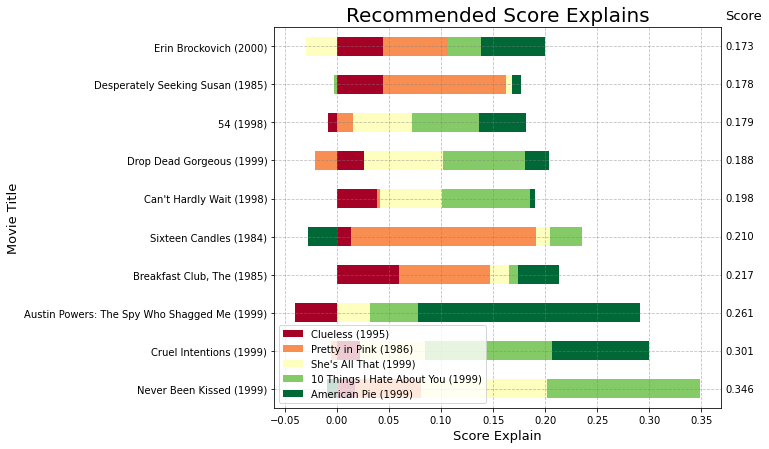

,Clueless (1995),Pretty in Pink (1986),She's All That (1999),10 Things I Hate About You (1999),American Pie (1999)
title,,,,,
Never Been Kissed (1999),0.016899,0.063854,0.120851,0.147539,-0.009500
Cruel Intentions (1999),0.022359,-0.005302,0.062430,0.122024,0.093265
Austin Powers: The Spy Who Shagged Me (1999),-0.040619,0.000323,0.031480,0.046170,0.213004
"Breakfast Club, The (1985)",0.059337,0.088071,0.018208,0.008195,0.039452
Sixteen Candles (1984),0.013299,0.177934,0.013302,0.030924,-0.027585
Can't Hardly Wait (1998),0.038365,0.002635,0.059961,0.084904,0.004589
Drop Dead Gorgeous (1999),0.025695,-0.021058,0.076212,0.079039,0.023068
54 (1998),-0.008444,0.015412,0.057044,0.063830,0.045173
Desperately Seeking Susan (1985),0.044718,0.117869,0.005656,-0.002440,0.008860


time: 299 ms (started: 2021-02-16 19:26:21 +09:00)


In [71]:
recommended_df = get_recommended_df(user_to_idx[mania_id], minia_model)
show_recommended_score_explain(recommended_df, user_to_idx[mania_id], minia_model, mania_movie_id, mania_title)

- 추천된 영화의 정보
    ![recommand](https://user-images.githubusercontent.com/16831323/108052154-1337f280-708f-11eb-80bf-d96492e8dba0.png)
- 하이틴 로맨스 마니아로써 단언컨데 추천 목록에서 하이틴이라고 할 수 있을만한 영화는 25살의 키스와 범위를 넓히면 조찬 클럽과 사랑보다 아름다운 유혹 정도이다. 하이틴 로맨스가 충분한 수의 마니아를 확보한 장르라고 생각했는데 잘못된 가정이었을 수 있었던 듯 싶다. 가설을 긍정적인 뒷받침해 줄만한 결과륻 가장 높은 score를 가지는 영화가 25살의 키스라는 점이다. SF나 전쟁물로 장르를 틀었더라면 더 마니악한 결과를 볼 수 있지 않았을까 생각해 본다.

## 결론
---

### 프로젝트 평가
1. CSR matrix가 정상적으로 만들어졌다. 사용자와 아이템 개수를 바탕으로 정확한 사이즈로 만들었다.
    ```python
    indptr: [     0     53    169 ... 836477 836478 836483](6041)
    indices: [   0    1    2 ...  204 1151 2047](836483)
    data: [5 3 3 ... 5 5 5](836483)
    ```
    - indptr의 길이는 row의 개수보다 하나가 더 많은 값이 되어야한다. 이번 프로젝트에서 row 값은 ratings의 user_id이므로, 초기 `ratings['user_id'].nunique()`값(6039) + 나의 id(1) + 1 = 6041이 되므로 올바르게 생성되었다.
    - indices의 길이는 data의 값에 해당하는 column index이므로 data와 그 길이가 동일하고, 이번 프로젝트에서는 ratings의 총 데이터 길이(rows)와 같아야 한다. 길이가 836483로 ratings의 rows 수와 동일하므로 indices와 data 모두 정확한 사이즈로 생성되었다.


2. MF 모델이 정상적으로 훈련되어 그럴듯한 추천이 이루어졌다. 사용자와 아이템 벡터 내적수치가 의미있게 형성되었다.
    - 본 실험에서 선호 영화들과 비슷한 장르인 로맨스 코메디 영화들이 추천되었고, score는 0.247 ~ 0.167 사이로 측정되었다.


3. 비슷한 영화 찾기와 유저에게 추천하기의 과정이 정상적으로 진행되었다.MF모델이 예측한 유저 선호도 및 아이템간 유사도, 기여도가 의미있게 측정되었다.

### 회고
- 이번 프로젝트를 하면서 가장 흥미로웠던 점은 추가 실험의 가설이 모두 틀렸다는 것이었다. 그럴듯해보였지만 확인하기 전까지는 확신해서는 안된다는 것을 다시 한번 느끼게 되었다. 더불어서 추가실험2를 통해 명백한 실험결과가 있더라도 실험과정에서의 착오 있을 수 있기에 과정이 검증되지 않은 이상 결과를 완전히 믿는 것 역시 위험한 판단인 점 역시 되세기게 되었다. 

## Code Collection
---

#### init_gpu

In [1]:
import tensorflow as tf

def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs\n\n")
      except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e, "\n\n")

In [2]:
init_gpu()

1 Physical GPUs, 1 Logical GPUs




#### show_preference_df_plot

In [3]:
import matplotlib.pyplot as plt

def show_preference_df_plot(preference_df, title=""):
    df = pd.DataFrame({ 'title' : preference_df['title'].values, 
                        'preferences' : preference_df['preference'].values})
    df = df.set_index('title')

    ax = df.plot(kind='bar', ylim=(0,1), color=['#6CCECB'])
    ax.grid(True, axis='y', color='gray', alpha=0.5, linestyle='dashed')
    if len(title) == 0:  ax.set_title('Preference of My Favorite Movies', {'fontsize': 15})
    else :  ax.set_title(title, {'fontsize': 15})
    
    for i, p in enumerate(ax.patches):
        left, bottom, width, height = p.get_bbox().bounds
        ax.annotate(f'{df.iloc[i].values[0]:.3f}',
                    (left+width/2, height*0.94),
                    ha='center')
        
    mean_val = df['preferences'].mean()
    ax.axhline(mean_val, color="#3e7371", linestyle='dashed')
    ax.text(1.01, mean_val, f'mean\n{mean_val:.3f}', va='center', ha="left",
            transform=ax.get_yaxis_transform())
    
    min_val = df['preferences'].min()
    ax.axhline(min_val, color="#3e7371", linestyle='dashed')
    ax.text(1.01, min_val, f'min\n{min_val:.3f}', va='center', ha="left",
            transform=ax.get_yaxis_transform())
    
    plt.legend(loc='lower left')
    plt.show()